In [1]:
import pandas as pd
import pysam

# Load gene list from features.tsv
features = pd.read_csv('features.tsv', header=None, sep='\t')
gene_list = features[1].tolist()

# Load barcodes from barcodes.tsv
barcodes_df = pd.read_csv('barcodes.tsv', header=None)
barcodes = barcodes_df[0].tolist()  # Assuming barcodes are in the first column

# Initialize dictionaries to hold counts and mismatches
gene_barcode_count = {}
gene_barcode_mismatches = {}

# Initialize the gene-to-index mapping
gene_to_index = {gene: idx for idx, gene in enumerate(gene_list)}

# Initialize barcode-to-index mapping
barcode_to_index = {barcode: idx for idx, barcode in enumerate(barcodes)}

# Open the BAM file
bam_file = pysam.AlignmentFile("./P-NR-U-8G-B05-68-V/possorted_genome_bam.bam", "rb")

In [2]:
# Process each read in the BAM file
number = 0
for read in bam_file:
    number = number+1
    if number % 1000000 == 0:
        print(number)
        
    tags = dict(read.tags)
    gene_name = tags.get('GN')  # Gene name tag
    mismatches = tags.get('nM', 0)  # Mismatch count (nM tag)
    barcode = tags.get('CB')  # Cell barcode tag (CB tag)

    if gene_name and barcode and gene_name in gene_to_index and barcode in barcode_to_index:
        # Create a tuple key for the gene-barcode pair
        key = (gene_name, barcode)

        # Update counts and mismatches for each gene-barcode pair
        if key not in gene_barcode_count:
            gene_barcode_count[key] = 0
            gene_barcode_mismatches[key] = 0
        gene_barcode_count[key] += 1
        gene_barcode_mismatches[key] += mismatches

1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000
30000000
31000000
32000000
33000000
34000000
35000000
36000000
37000000
38000000
39000000
40000000
41000000
42000000
43000000
44000000
45000000
46000000
47000000
48000000
49000000
50000000
51000000
52000000
53000000
54000000
55000000
56000000
57000000
58000000
59000000
60000000
61000000
62000000
63000000
64000000
65000000
66000000
67000000
68000000
69000000
70000000
71000000
72000000
73000000
74000000
75000000
76000000
77000000
78000000
79000000
80000000
81000000
82000000
83000000
84000000
85000000
86000000
87000000
88000000
89000000
90000000
91000000
92000000
93000000
94000000
95000000
96000000
97000000
98000000
99000000
100000000
101000000
102000000
103000000
104000000
105000000
106000000
107000000
108000000
109000000
110000000
11100000

In [7]:
import pandas as pd

# Create DataFrames directly from the dictionaries with a multi-level index approach
count_df = pd.DataFrame([
    (gene, barcode, count) for ((gene, barcode), count) in gene_barcode_count.items()],
    columns=['Gene', 'Barcode', 'Count']
).set_index(['Barcode', 'Gene'])

mismatch_df = pd.DataFrame([
    (gene, barcode, mismatches) for ((gene, barcode), mismatches) in gene_barcode_mismatches.items()],
    columns=['Gene', 'Barcode', 'Mismatches']
).set_index(['Barcode', 'Gene'])

# Unstack to create the full matrices with genes as columns and barcodes as rows
count_matrix = count_df['Count'].unstack(fill_value=0).reindex(index=barcodes, columns=gene_list, fill_value=0)
mismatch_matrix = mismatch_df['Mismatches'].unstack(fill_value=0).reindex(index=barcodes, columns=gene_list, fill_value=0)

# Save the matrices to CSV files
count_matrix.to_csv('240506_gene_barcode_counts.csv')
mismatch_matrix.to_csv('240506_gene_barcode_mismatches.csv')

print("Matrices saved to '240506_gene_barcode_counts.csv' and '240506_gene_barcode_mismatches.csv'.")


@1
@2
@3
@4
Matrices saved to '240506_gene_barcode_counts.csv' and '240506_gene_barcode_mismatches.csv'.


In [1]:
import pandas as pd
import anndata as ad

# Load the CSV files
counts_df = pd.read_csv('240506_gene_barcode_counts.csv', index_col=0)
mismatches_df = pd.read_csv('240506_gene_barcode_mismatches.csv', index_col=0)

/home/jeongbinpark/miniconda3/envs/JB_lipo/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import pandas as pd

# Assuming count_matrix and mismatch_matrix are loaded from CSV or defined in your environment
# count_matrix = pd.read_csv('gene_barcode_counts.csv', index_col=0)
# mismatch_matrix = pd.read_csv('gene_barcode_mismatches.csv', index_col=0)

# Step 1: Sum of count values for each gene
gene_total_counts = counts_df.sum(axis=0)

# Step 2: Sum of mismatch values for each gene
gene_total_mismatches = mismatches_df.sum(axis=0)

# Step 3: Divide the sum of mismatch values by the sum of count values for each gene
# Avoid division by zero by adding a small number (e.g., 1e-8) to the denominator
mismatch_ratio = gene_total_mismatches / (gene_total_counts + 1e-8)

# Step 4: Sort the ratio from high to low
sorted_mismatch_ratio = mismatch_ratio.sort_values(ascending=False)

# Optionally, display the sorted ratio values
print(sorted_mismatch_ratio)

# Create a DataFrame to hold all the data
result_df = pd.DataFrame({
    'Total Counts': gene_total_counts,
    'Total Mismatches': gene_total_mismatches,
    'Mismatch Ratio': sorted_mismatch_ratio
})

# Sorting the DataFrame by Mismatch Ratio in descending order for clarity
result_df = result_df.sort_values('Mismatch Ratio', ascending=False)

# Save to CSV
result_df.to_csv('gene_summary.csv', index=True, index_label='Gene')

print("Results have been saved to 'gene_summary.csv'.")

mm10___Gm10358      10.0
GRCh38_MT1H         10.0
mm10___Glt28d2      10.0
GRCh38_ITK          10.0
GRCh38_PLA2G2C      10.0
                    ... 
mm10___Gm13290       0.0
mm10___Gm13289       0.0
mm10___Gm13272       0.0
mm10___Ifnz          0.0
GRCh38_LINC00528     0.0
Length: 68886, dtype: float64
Results have been saved to 'gene_summary.csv'.


In [3]:
# Convert indices and columns to DataFrames for obs and var
obs_counts = counts_df.index.to_frame(name='Barcodes')
var_counts = counts_df.columns.to_frame(name='Genes')

obs_mismatches = mismatches_df.index.to_frame(name='Barcodes')
var_mismatches = mismatches_df.columns.to_frame(name='Genes')

# Convert the DataFrames to AnnData objects
adata_counts = ad.AnnData(X=counts_df.values, obs=obs_counts, var=var_counts)
adata_mismatches = ad.AnnData(X=mismatches_df.values, obs=obs_mismatches, var=var_mismatches)

# Optional: save the AnnData objects to disk in .h5ad format
adata_counts.write('240506_gene_barcode_counts.h5ad')
adata_mismatches.write('240506_gene_barcode_mismatches.h5ad')

print("AnnData objects have been created and saved.")

AnnData objects have been created and saved.


In [4]:
import scanpy as sc
import numpy as np

# Dividing mismatches by counts
ratio_data = adata_mismatches.X / adata_counts.X

# Create a new AnnData object for the calculated ratio
adata_ratio = ad.AnnData(X=ratio_data, obs=adata_counts.obs, var=adata_counts.var)

adata_original = sc.read_visium('./P-NR-U-8G-B05-68-V')
adata_original.X = adata_ratio.X.copy()
adata_ratio = adata_original
adata_ratio.write('240506_gene_barcode_ratio.h5ad')

print("The ratio AnnData object has been created and saved.")

/tmp/ipykernel_28238/2046019815.py:5: RuntimeWarning: invalid value encountered in divide
  ratio_data = adata_mismatches.X / adata_counts.X
/home/jeongbinpark/miniconda3/envs/JB_lipo/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jeongbinpark/miniconda3/envs/JB_lipo/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


The ratio AnnData object has been created and saved.


In [5]:
adata_ratio.var

,gene_ids,feature_types,genome
GRCh38_MIR1302-2HG,GRCh38_ENSG00000243485,Gene Expression,GRCh38
GRCh38_FAM138A,GRCh38_ENSG00000237613,Gene Expression,GRCh38
GRCh38_OR4F5,GRCh38_ENSG00000186092,Gene Expression,GRCh38
GRCh38_AL627309.1,GRCh38_ENSG00000238009,Gene Expression,GRCh38
GRCh38_AL627309.3,GRCh38_ENSG00000239945,Gene Expression,GRCh38
...,...,...,...
mm10___AC124606.1,mm10___ENSMUSG00000095523,Gene Expression,mm10
mm10___AC133095.2,mm10___ENSMUSG00000095475,Gene Expression,mm10
mm10___AC133095.1,mm10___ENSMUSG00000094855,Gene Expression,mm10
mm10___AC234645.1,mm10___ENSMUSG00000095019,Gene Expression,mm10


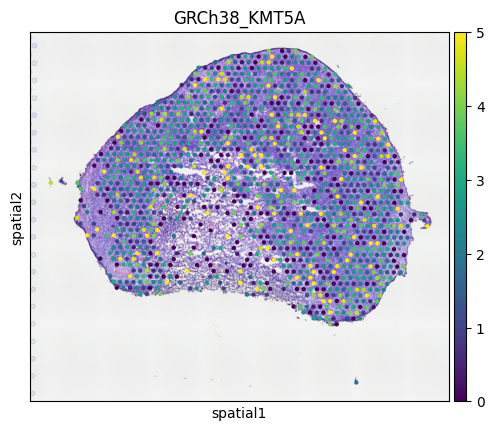

In [4]:
sc.pl.spatial(adata_ratio, color = 'GRCh38_KMT5A', vmax = 5)

/home/jeongbinpark/miniconda3/envs/JB_lipo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


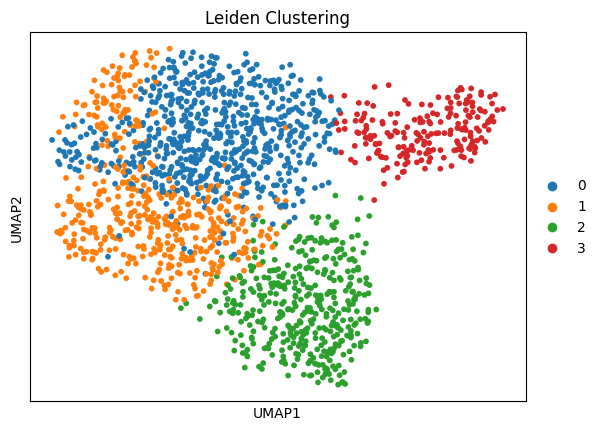

In [68]:
import scanpy as sc
import numpy as np

# Load your AnnData object
adata = adata_ratio

# Replace all inf and -inf values in adata.X with zero
adata.X = np.where(np.isinf(adata.X), 0, adata.X)
adata.X = np.where(np.isnan(adata.X), 0, adata.X)

# Run PCA to reduce dimensionality
sc.pp.pca(adata, n_comps=60)  # You might need to adjust the number of components based on your dataset

# Compute the neighborhood graph
sc.pp.neighbors(adata)

# Run clustering using the Leiden algorithm
sc.tl.leiden(adata, resolution = 0.6)

# Optionally, compute UMAP for visualization
sc.tl.umap(adata)

# Plotting the results
sc.pl.umap(adata, color='leiden', title='Leiden Clustering')

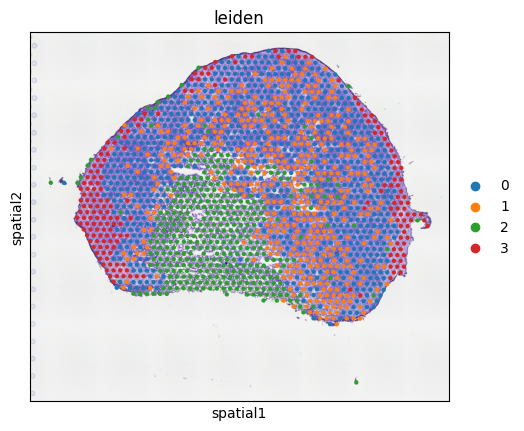

In [69]:
sc.pl.spatial(adata, color = 'leiden')

/home/jeongbinpark/miniconda3/envs/JB_lipo/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


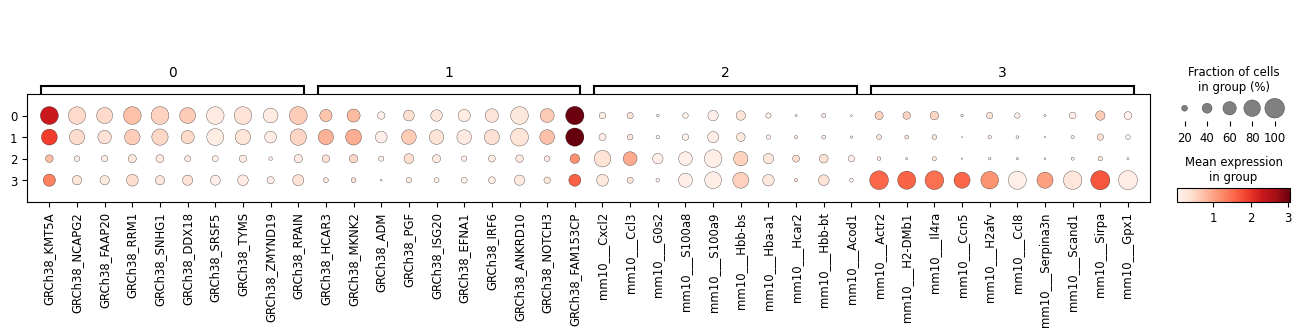

In [83]:
adata.var_names_make_unique()
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata, groups = None, n_genes = 10, dendrogram=False)

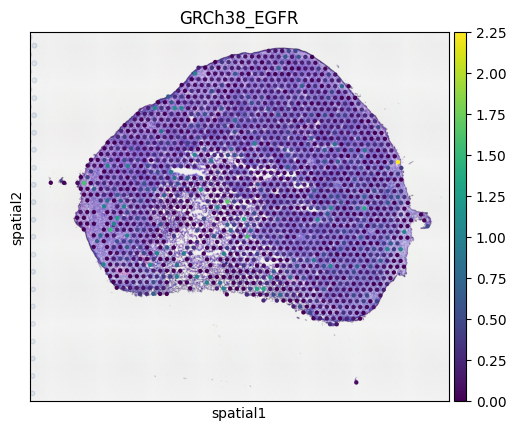

In [5]:
sc.pl.spatial(adata_ratio, color = 'GRCh38_EGFR')

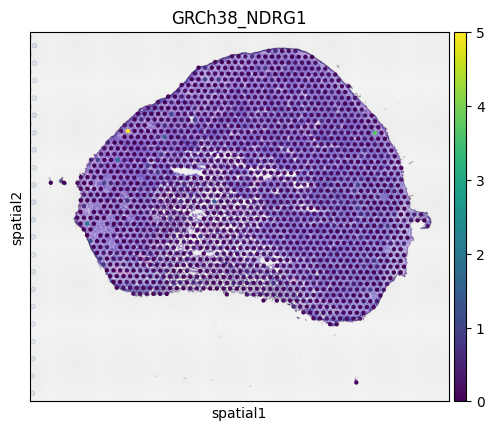

In [6]:
sc.pl.spatial(adata_ratio, color = 'GRCh38_NDRG1')